# NFDI demonstrator by Data Analytics in Engineering

Authors: Julius Herb <herb@mib.uni-stuttgart.de>, Sanath Keshav <keshav@mib.uni-stuttgart.de>, Felix Fritzen <fritzen@mib.uni-stuttgart.de>

Affiliation: Heisenberg Professorship Data Analytics in Engineering, Institute of Applied Mechanics, University of Stuttgart | Universitätsstr. 32, 70569 Stuttgart | https://www.mib.uni-stuttgart.de/dae

>**Funding acknowledgment**
>>
>Contributions by Felix Fritzen are partially funded by Deutsche Forschungsgemeinschaft (DFG, German Research Foundation) under Germany’s Excellence Strategy - EXC 2075 – 390740016. Felix Fritzen is funded by Deutsche Forschungsgemeinschaft (DFG, German Research Foundation) within the Heisenberg program DFG-FR2702/8 - 406068690 and DFG-FR2702/10 - 517847245.
>
>Contributions of Julius Herb are partially funded by the Ministry of Science, Research and the Arts (MWK) Baden-Württemberg, Germany, within the Artificial Intelligence Software Academy (AISA).
>
>The authors acknowledge the support by the Stuttgart Center for Simulation Science (SimTech).

## Thermal homogenization problem in 2D with periodic boundary conditions

### Introduction

While it is assumed in many applications that components are characterized by a homogeneous microstructure, this is not always the case.
In fact, materials often exhibit heterogeneities, which can affect the material behavior drastically.
Pronounced examples of this are Metal-Matrix Composites (MMCs). To determine the material behavior in multi-scale simulations, homogenization problems have to be solved.
In computational homogenization [1], the overall goal is to determine the effective material behavior of a heterogeneous material based on a given microstructure using numerical simulations.
For that, the microstructure is assumed to be a periodic continuation of a representative volume element (RVE) with the domain $\Omega \subset \mathbb{R}^2$.
The microscopic position in the RVE is denoted by $\boldsymbol{x} \in \Omega$, while the macroscopic position is referred to as $\overline{\boldsymbol{x}}$.

Each RVE is assumed to consist of two phases.
Hence, the domain is decomposed into a part of a matrix material $\Omega_0$ and a part of inclusions $\Omega_1$.
Based on that, the following indicator functions are defined as
\begin{align}
	\chi_0, \chi_1: \Omega \to \{0, 1\},
	&& \chi_0(\boldsymbol{x}) = \begin{cases}
		1 & \boldsymbol{x} \in \Omega_0 \,,\\
		0 & \boldsymbol{x} \notin \Omega_0 \,.
	\end{cases}
	&& \chi_1(\boldsymbol{x}) = \begin{cases}
		1 & \boldsymbol{x} \in \Omega_1 \,,\\
		0 & \boldsymbol{x} \notin \Omega_1 \,. 
	\end{cases}
\end{align}
Using $\chi_0$ and $\chi_1$, the volume fraction of both phases $f_i$ with $i \in \{0, 1\}$ is computed as
\begin{equation}
	f_i = \int_\Omega \chi_i(\boldsymbol{x}) \mathrm{d}\boldsymbol{x} \,.
\end{equation}
Often, the microstructures for homogenization problems are given through images, i.e., each pixel of an image defines the assignment of the corresponding area of the microstructure to one of the two phases.
Hence, it is convenient to use the underlying regular grid of these images as a discretization of the domain $\Omega$.
As it is common in computational homogenization, the domain of the RVE is chosen to be a cell-centered unit cell around the origin that is defined as
\begin{equation}
	\Omega = \left[-\frac{l_1}{2},\,\frac{l_1}{2}\right] \times \left[-\frac{l_2}{2},\,\frac{l_2}{2}\right] \,.
\end{equation}

### Modeling

This demonstrator showcases a thermal homogenization problem [1] of a 2D microstructure.
For this problem, the temperature field $\theta(\boldsymbol{x}) \in \mathbb{R}$ is the primary variable.
Besides, as secondary variables there are the temperature gradient $\boldsymbol{g}(\boldsymbol{x}) = \nabla \theta(\boldsymbol{x}) \in \mathbb{R}^2$ and the heat flux $\boldsymbol{q}(\boldsymbol{x}) \in \mathbb{R}^2$.
These secondary variables are related by Fourier's law:
\begin{equation}
	\boldsymbol{q}(\boldsymbol{x}) = -\boldsymbol{\kappa}(\boldsymbol{x}) \boldsymbol{g}(\boldsymbol{x}) \,,
\end{equation}
where the heat conductivity tensor $\boldsymbol{\kappa}(\boldsymbol{x}) \in \mathrm{Sym} \left( \mathbb{R}^{2 \times 2} \right)$ has to be symmetric and positive definite and is different in each phase.
The homogenization or volume averaging operator $\langle \bullet \rangle$ is used to obtain the macroscopic representation $\overline{\boldsymbol{q}}$ of a general microscopic field $\boldsymbol{q}(\boldsymbol{x})$ via
\begin{equation}
	\overline{\boldsymbol{q}} = \langle \boldsymbol{q} \rangle = \frac{1}{|\Omega|} \int_{\Omega} \boldsymbol{q}(\boldsymbol{x}) \mathrm{d}\boldsymbol{x} \,.
\end{equation}
The governing equation for thermal homogenization problems is the PDE for steady-state heat conduction,
\begin{align}
	\mathrm{div}\left(\boldsymbol{q}(\boldsymbol{x})\right) = 0 \,, && \boldsymbol{x} \in \Omega \,.
\end{align}

For homogenization problems, it is convenient to decompose the primary variable into parts that are either related to macroscopic or microscopic quantities.
In the case of thermal homogenization problems, the temperature field is decomposed into
\begin{align}
	\theta(\boldsymbol{x}) = \overline{\theta} + \overline{\boldsymbol{g}} \cdot \boldsymbol{x} + \tilde{\theta}(\boldsymbol{x}) \,, && \boldsymbol{x} \in \Omega \,,
\end{align}
with the macroscopic temperature $\overline{\theta}$ (here we set $\overline{\theta} = 0 \, [\mathrm{K}]$ w.l.o.g.), the temperature field $\overline{\boldsymbol{g}} \cdot \boldsymbol{x}$ that is induced by a macroscopic temperature gradient $\overline{\boldsymbol{g}}$, and the remaining temperature fluctuation field $\tilde{\theta}(\boldsymbol{x})$.

The sought-after quantity in thermal homogenization problems is mainly the effective heat conductivity tensor $\overline{\boldsymbol{\kappa}}$ that determines the homogenized response of the material,
\begin{equation}
	\overline{\boldsymbol{q}} = -\overline{\boldsymbol{\kappa}} \, \overline{\boldsymbol{g}} \,.
\end{equation}
It is obtained by solving the PDE for two linearly independent load cases $\overline{\boldsymbol{g}} \in \left\{ \overline{\boldsymbol{g}}^{(1)}, \overline{\boldsymbol{g}}^{(2)} \right\}$.
Then, the effective heat counductivity tensor $\overline{\boldsymbol{\kappa}} \in \mathrm{Sym}\left( \mathbb{R}^{2 \times 2} \right)$ is recovered by volume averaging the computed heat fluxes $\overline{\boldsymbol{q}}^{(j)} = \left\langle \boldsymbol{q}^{(j)} \right\rangle$ for both load cases $j \in \{1, 2\}$ and calculating
\begin{align}
	\overline{\boldsymbol{\kappa}} = -\begin{bmatrix} \overline{\boldsymbol{q}}^{(1)} & \overline{\boldsymbol{q}}^{(2)} \end{bmatrix} \begin{bmatrix} \overline{\boldsymbol{g}}^{(1)} & \overline{\boldsymbol{g}}^{(2)} \end{bmatrix}^{-1} \in \mathbb{R}^{2 \times 2} \,.
\end{align}

### Simulation

The classical approach to solving homogenization problems is using Finite Element Method (FEM) simulations.
This involves deriving a variational formulation and leads to an algebraic linear system that can be solved e.g. using iterative methods.
For this, a matrix-free conjugate gradient (CG) method can be used. However, for finely resolved discretizations the system becomes ill-conditioned and this leads to slow convergence of the unpreconditioned CG method.
As an alternative, FFT-based solvers (e.g. the Moulinec-Suquet [2]) scheme has been used as an efficient alternative, but this can introduce artifacts due to the Gibbs phenomenon.

In recent years, attempts have been made to merge very efficient FFT-based solvers like the collocation method of Moulinec-Suquet [2] into the established framework of the finite element method (FEM).
A breakthrough in this regard was achieved with the development of Fourier-Accelerated Nodal Solvers (FANS) that are published in [3].
As the name suggests, the primary variables for FANS are the nodal values, i.e., the temperature fluctuation field $\tilde{\theta}(\boldsymbol{x})$ for the thermal homogenization problem, respectively.
FANS can be used as a preconditioner for a matrix-free CG method, which leads to the *FANS-CG* algorithm that converges rapidly for homogenization problems with periodic boundary conditions.

In addition to our open-source CPU-based implementation <https://github.com/DataAnalyticsEngineering/FANS> of *FANS-CG* tailored to HPC clusters, we are developing rapid GPU-based solvers (including a GPU-based version of *FANS-CG*) that can be used to solve small and medium-sized homogenization problems in near real-time [4].

### Machine-learned surrogate models

TODO: Documentation

Reference: [5]

### References:

[1] Fritzen, F. (2011). Microstructural modeling and computational homogenization of the physically linear and nonlinear constitutive behavior of micro-heterogeneous materials. KIT Scientific Publishing. https://doi.org/10.5445/KSP/1000023534 (esp. section 4.2)

[2] Moulinec, H., & Suquet, P. (1998). A numerical method for computing the overall response of nonlinear composites with complex microstructure. In Computer Methods in Applied Mechanics and Engineering (Vol. 157, Issues 1–2, pp. 69–94). Elsevier BV. https://doi.org/10.1016/s0045-7825(97)00218-1

[3] Leuschner, M., & Fritzen, F. (2017). Fourier-Accelerated Nodal Solvers (FANS) for homogenization problems. In Computational Mechanics (Vol. 62, Issue 3, pp. 359–392). Springer Science and Business Media LLC. https://doi.org/10.1007/s00466-017-1501-5

[4] Herb, J., & Fritzen, F. (2025). FNO-CG: Accelerating CG solvers with Fourier Neural Operators (FNOs) \[Computer software\]. In preparation.

[5] Keshav, S., Herb, J., & Fritzen, F. (2025). Voigt-Reuss-Net: A universal approach to microstructure-property forecasting with physical guarantees. In preparation.

### Imports

In [1]:
import torch
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
import ipywidgets
from utils import *
from plotting import *
import timeit
import time
%matplotlib widget

### Configuration

Set `device` to your available device. Use if possible a NVIDIA GPU of a recent generation (we recommend Ada Lovelace or Hopper).
It is also possible to run the demonstrator on the CPU (by setting `device = "cpu"`) but with significantly worse performance.

In [2]:
dtype = torch.float64
device = "cuda" if torch.cuda.is_available() else "cpu"
args = {"device": device, "dtype": dtype}
print(args)

{'device': 'cuda', 'dtype': torch.float64}


### Load microstructures dataset from DaRUS

Dataset citation: Lißner, J. (2023). "Microstructure feature engineering data", https://doi.org/10.18419/DARUS-3366, DaRUS, V1

Related publication: Lißner, J., & Fritzen, F. (2024). Microstructure homogenization: human vs machine. Adv. Model. and Simul. in Eng. Sci. 11, 21. https://doi.org/10.1186/s40323-024-00275-1

The dataset contains image data of periodic microstructural representative volume elements (RVE), as well as the effective heat conductivity for multiple phase contrasts.
Various features and feature descriptors (explained in the related publication) are provided, as well as the computation thereof. The features were used in a machine learning regression setting (see related publication).
The data is split into two sets, one with 30.000 samples containing only one inclusion type per RVE and another set of 1.500 samples containing mixed inclusions.

In [3]:
file_path = os.path.join("data", "feature_engineering_data.h5")
group_name = "train_set"

if not os.path.isfile(file_path):
    print("Downloading data from DaRUS...")
    darus_download(repo_id=3366, file_id=4, file_path=file_path)

samples = MicrostructureImageDataset(
    file_path=file_path,
    group_name=group_name
)
print('Number of samples in dataset:', len(samples))

Number of samples in dataset: 30000


### Load microstructure and plot it

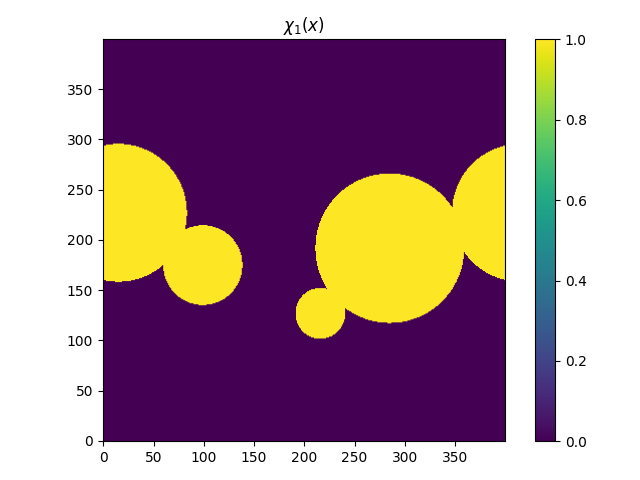

In [4]:
idx = 37
image = samples[idx].unsqueeze(0)

fig, ax = plt.subplots(1, 1)
cax = ax.imshow(image[0].T.cpu(), origin="lower")
fig.colorbar(cax, ax=ax)
ax.set_title(r"$\chi_1(x)$")
fig.tight_layout()
plt.show()

### Define material parameters and loading

Often, the heat conduction in each phase is assumed to be isotropic, that is, $\boldsymbol{\kappa}_0 = \kappa_0 \boldsymbol{I} \,, \boldsymbol{\kappa}_1 = \kappa_1 \boldsymbol{I}$ with $\kappa_0, \kappa_1 \in \mathbb{R}$.
The assumption of isotropy is only made for simplicity and does not represent a restriction on the presented algorithms. With that, the following coefficient field completely describes the local heat conductivity of the microstructure,
\begin{align}
	\kappa(\boldsymbol{x}) = \kappa_0 \chi_0(\boldsymbol{x}) + \kappa_1 \chi_1(\boldsymbol{x}) \,.
\end{align}
For now, we set $\kappa_0 = 1$, $\kappa_1 = 0.2$, and the loading (i.e. the macroscopic temperature gradient $\boldsymbol{g}$) to
\begin{equation}
    \bar{\boldsymbol{g}}^{(1)} = \begin{bmatrix} 1 \\ 0 \end{bmatrix} \,, \quad \bar{\boldsymbol{g}}^{(2)} = \begin{bmatrix} 0 \\ 1 \end{bmatrix} \,.
\end{equation}
Both the material parameter $\kappa_1$ and the direction of the loadings $\bar{\boldsymbol{g}}^{(1)}$, $\bar{\boldsymbol{g}}^{(2)}$ can be changed later in the interactive widget.

Material parameters:
 tensor([[1.0000],
        [0.2000]])
Loading:
 tensor([[1., 0.],
        [0., 1.]], dtype=torch.float64)


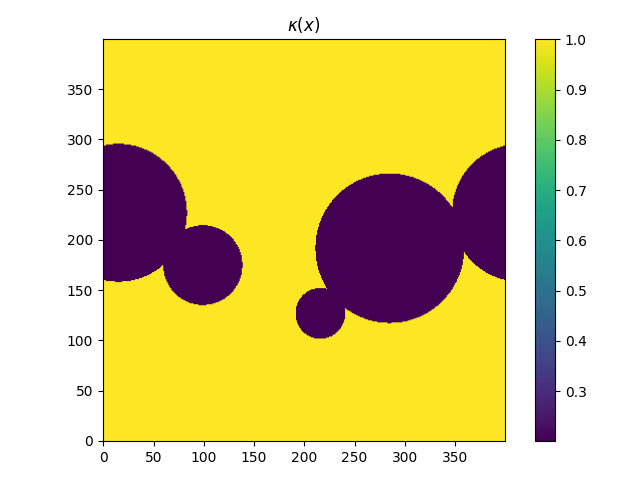

In [5]:
params = torch.tensor([1., 0.2]).reshape(2, 1)
print("Material parameters:\n", params)

assert params.min() > 0, "thermal conductivity has to be positive"
assert (params.min() / params.max() <= 0.9), "phase contrast should not be close to 1"

param_field = get_param_fields(image, params).to(**args).unsqueeze(0)
loading = torch.eye(2, **args)
print("Loading:\n", loading.cpu())

fig, ax = plt.subplots(1, 1)
cax = ax.imshow(param_field[0,0].T.cpu(), origin="lower")
fig.colorbar(cax, ax=ax)
ax.set_title(r"$\kappa(x)$")
fig.tight_layout()
plt.show()

### Load PyTorch model that performs the simulation

The simulation is defined as a PyTorch model is using our *FNO-CG* [4] software package that offers GPU-accelerated implementation of preconditioned iterative solvers. In this case, the algorithm of the *FANS-CG* [3] solver is performed on the GPU (or CPU).

Optionally, the model can be compiled with *TorchDynamo* to enable faster execution (set `compile_model=True`). However, the compilation itself takes a few seconds. If the `ipykernel` crashes during compilation or while loading a precompiled model it is recommended to set `compile_model=False`.

Be aware that compilation using *TorchDynamo* does not always accelerate the model. Particularly on older NVIDIA architectures it can introduce additional overhead.
Nevertheless, models that have been compiled into a C++ shared library (*.so file) can be also used outside of a Python environment.

In [6]:
model = load_fnocg_model(problem="thermal", dim=2, bc="per", n_layers=15, device=device, dtype=dtype, compile_model=False)

Creating model in Python... Successful


### Load PyTorch surrogate model (Voigt-Reuss-Net)

TODO: Documentation

In [20]:
vrnn = torch.jit.load(os.path.join("models", "vrnn_therm2D_jit.pt")).to(device=device, dtype=torch.float32)
compile_model = False
if compile_model:
    vrnn = torch.compile(vrnn, mode="reduce-overhead")

def surrogate(param_field):
    kappa0 = param_field.min().item()
    features = get_surrogate_features(param_field).to(device=device, dtype=torch.float32)
    # features = torch.rand((1,53), device=device, dtype=torch.float32)
    return unpack_sym(vrnn(features), dim=2).squeeze() * kappa0

### Run benchmark of simulation

Runtime for a single model evaluation should be <10ms on a state-of-the-art NVIDIA GPU, <150ms on an older (or e.g. notebook) NVIDIA GPU, and <1000ms on the CPU.
In this time, the model performs a FEM simulation with 160000 degrees of freedom for each given microstructure and each given loading, respectively.

Batched model evaluations are also possible to achieve a high-throughput analysis, but when using *TorchDynamo* the model has to be compiled with appropriate settings.

In [21]:
def run_simulation():
    with torch.inference_mode():
        model(param_field.to(**args), loading.to(**args))
        if device != "cpu":
            torch.cuda.synchronize()

n_runs = 10
for _ in range(3):
    run_simulation()
model_time = timeit.timeit(run_simulation, number=n_runs) / n_runs
print(f"Runtime per execution: {model_time*1000.:.4f}ms")

Runtime per execution: 8.6921ms


### Run benchmark of surrogate model

In [22]:
def run_surrogate():
    with torch.inference_mode():
        surrogate(param_field)
    if device != "cpu":
        torch.cuda.synchronize()

n_runs = 10
for _ in range(3):
    run_surrogate()
model_time = timeit.timeit(run_surrogate, number=n_runs) / n_runs
print(f"Runtime per execution: {model_time*1000.:.4f}ms")

Runtime per execution: 1.3458ms


### Run simulation model to obtain full-field solutions

The PyTorch model maps the field of material parameters `param_field` (in this case $\kappa(\boldsymbol{x})$) and the `loading` (in this case $\begin{bmatrix} \bar{\boldsymbol{g}}^{(1)}, \bar{\boldsymbol{g}}^{(2)} \end{bmatrix}$) to the variable `field`, which includes the temperature fluctuation fields $\tilde{\theta}(\boldsymbol{x})$ and the heat flux vector-fields $\boldsymbol{q}(\boldsymbol{x})$.

The shapes of the tensors are as follows:
- `param_field` with material parameter $\kappa(\boldsymbol{x})$: $n_{\mathrm{microstructures}} \times 1 \times n \times n$
- `loading` with macroscopic temperature gradients $\bar{\boldsymbol{g}}^{(i)}$: $n_{\mathrm{loadings}} \times 2$
- `temp` with temperature fluctuations $\tilde{\theta}(\boldsymbol{x})$: $n_{\mathrm{microstructures}} \times n_{\mathrm{loadings}} \times 1 \times n \times n$
- `flux` with heat flux vector-field $\boldsymbol{q}(\boldsymbol{x})$: $n_{\mathrm{microstructures}} \times n_{\mathrm{loadings}} \times 2 \times n \times n$
- `field` with stacked `temp` and `flux`: $n_{\mathrm{microstructures}} \times n_{\mathrm{loadings}} \times 3 \times n \times n$

In this case, we have $n_{\mathrm{microstructures}} = 1$, $n_{\mathrm{loadings}} = 2$, and $n = 400$.

In [11]:
with torch.inference_mode():
    field = model(param_field.to(**args), loading.to(**args))
    temp = field[..., :1, :, :].cpu()
    flux = field[..., 1:, :, :].cpu()
print("param_field.shape:", param_field.shape)
print("loading.shape:", loading.shape)
print("temp.shape:", temp.shape)
print("flux.shape:", flux.shape)
print("field.shape:", field.shape)

param_field.shape: torch.Size([1, 1, 400, 400])
loading.shape: torch.Size([2, 2])
temp.shape: torch.Size([1, 2, 1, 400, 400])
flux.shape: torch.Size([1, 2, 2, 400, 400])
field.shape: torch.Size([1, 2, 3, 400, 400])


In [12]:
surrogate(param_field.to(**args))

tensor([[0.7545, 0.0093],
        [0.0093, 0.6308]], device='cuda:0', grad_fn=<MulBackward0>)

### Visualize loadings using streamlines

The following plot shows the temperature field $\theta(\boldsymbol{x})$ together with streamlines due to the heat flux vector-field $\boldsymbol{q}(\boldsymbol{x})$ for both load cases $\overline{\boldsymbol{g}} \in \left\{ \overline{\boldsymbol{g}}^{(1)}, \overline{\boldsymbol{g}}^{(2)} \right\}$.

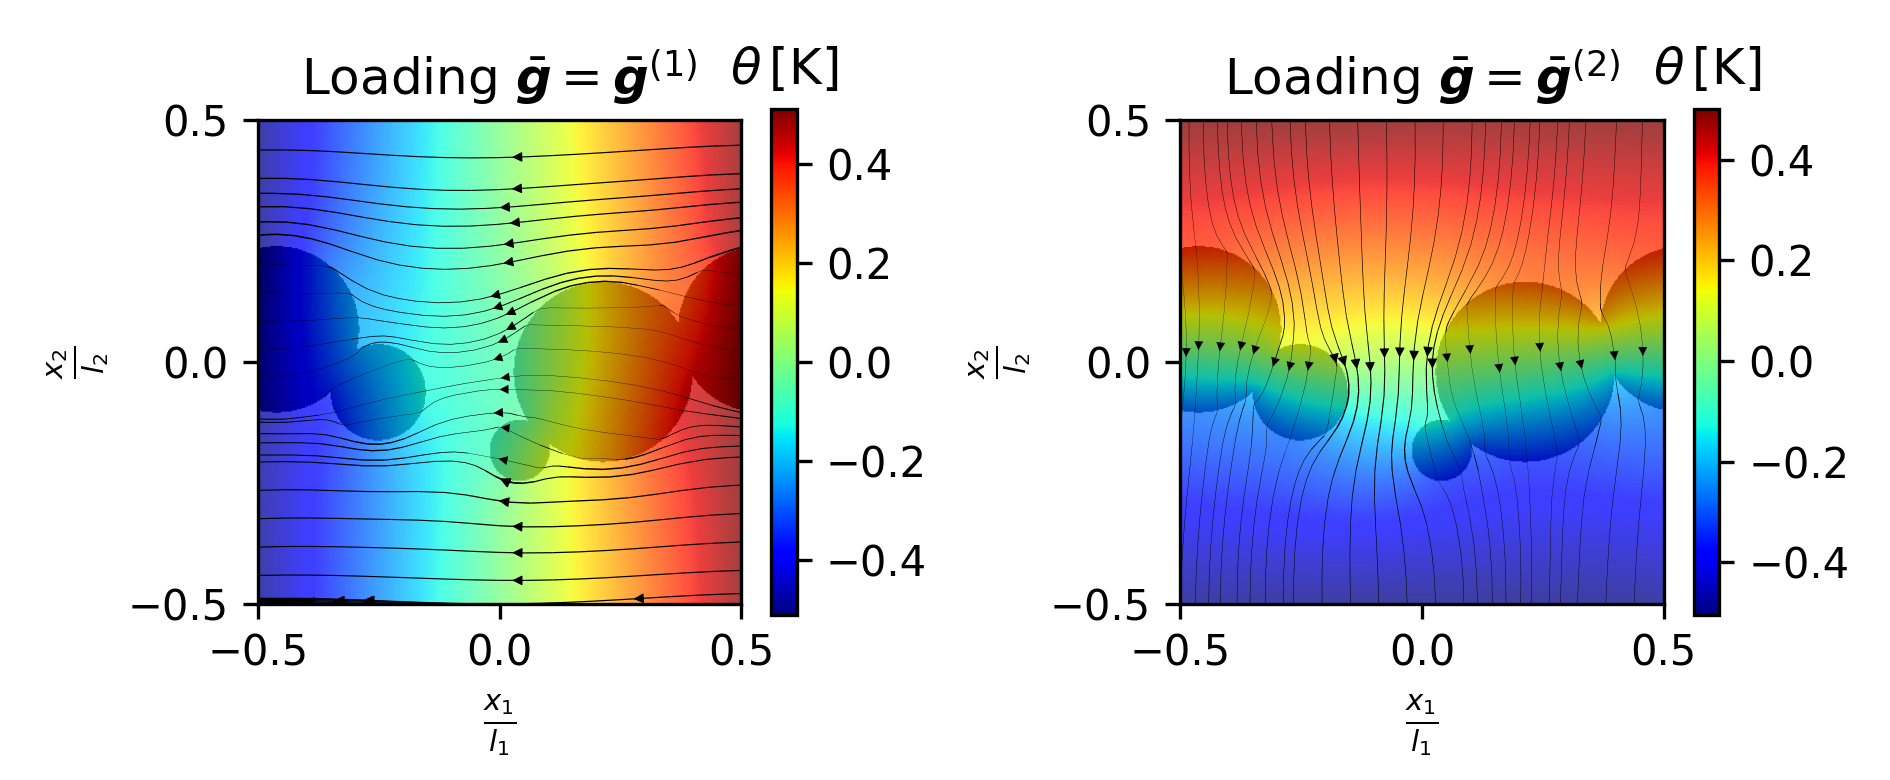

In [13]:
X, Y = get_node_coords(temp)
temp_macro = get_macro_temp(temp[..., :1, :, :], loading.cpu())
loading_names = [r"$\bar{\boldsymbol{g}}=\bar{\boldsymbol{g}}^{(1)}$", r"$\bar{\boldsymbol{g}}=\bar{\boldsymbol{g}}^{(2)}$"]

fig, ax = plt.subplots(1, len(loading_names), figsize=[6.3, 2.6], dpi=300)
for load_i, load_name in enumerate(loading_names):
    pcm = ax[load_i].imshow(temp_macro[0, load_i, 0].T.cpu().numpy(), origin="lower", extent=[-0.5, 0.5, -0.5, 0.5], cmap="jet")
    clb = plt.colorbar(pcm, ax=ax[load_i])
    clb.ax.set_title(r"$\theta \,\mathrm{[K]}$")
    ax[load_i].imshow(image[0].T.cpu().numpy(), origin="lower", extent=[-0.5, 0.5, -0.5, 0.5], cmap="Greys", alpha=0.25, rasterized=True)
    flux_mag = flux[0].norm(dim=-3)[load_i].T
    lw = flux_mag * 0.5 / flux_mag.max().item()
    ax[load_i].streamplot(X.cpu().numpy(), Y.cpu().numpy(), flux[0, load_i, 0].T.cpu().numpy(), flux[0, load_i, 1].T.numpy(), color='k', density=0.6, broken_streamlines=False, linewidth=lw.numpy(), arrowsize=0.5)
    ax[load_i].set_title(rf"Loading {load_name}")
for ax_handle in ax.ravel():
    ax_handle.set_xlim(-0.5, 0.5)
    ax_handle.set_ylim(-0.5, 0.5)
    ax_handle.set_xticks([-0.5, 0.0, 0.5])
    ax_handle.set_yticks([-0.5, 0.0, 0.5])
    ax_handle.set_xlabel(r"$\frac{x_1}{l_1}$")
    ax_handle.set_ylabel(r"$\frac{x_2}{l_2}$")
plt.tight_layout()
plt.show()

### Plot temperature fluctuation fields:

The following plot shows the temperature fluctuation field $\tilde{\theta}(\boldsymbol{x})$ for both load cases $\overline{\boldsymbol{g}} \in \left\{ \overline{\boldsymbol{g}}^{(1)}, \overline{\boldsymbol{g}}^{(2)} \right\}$.

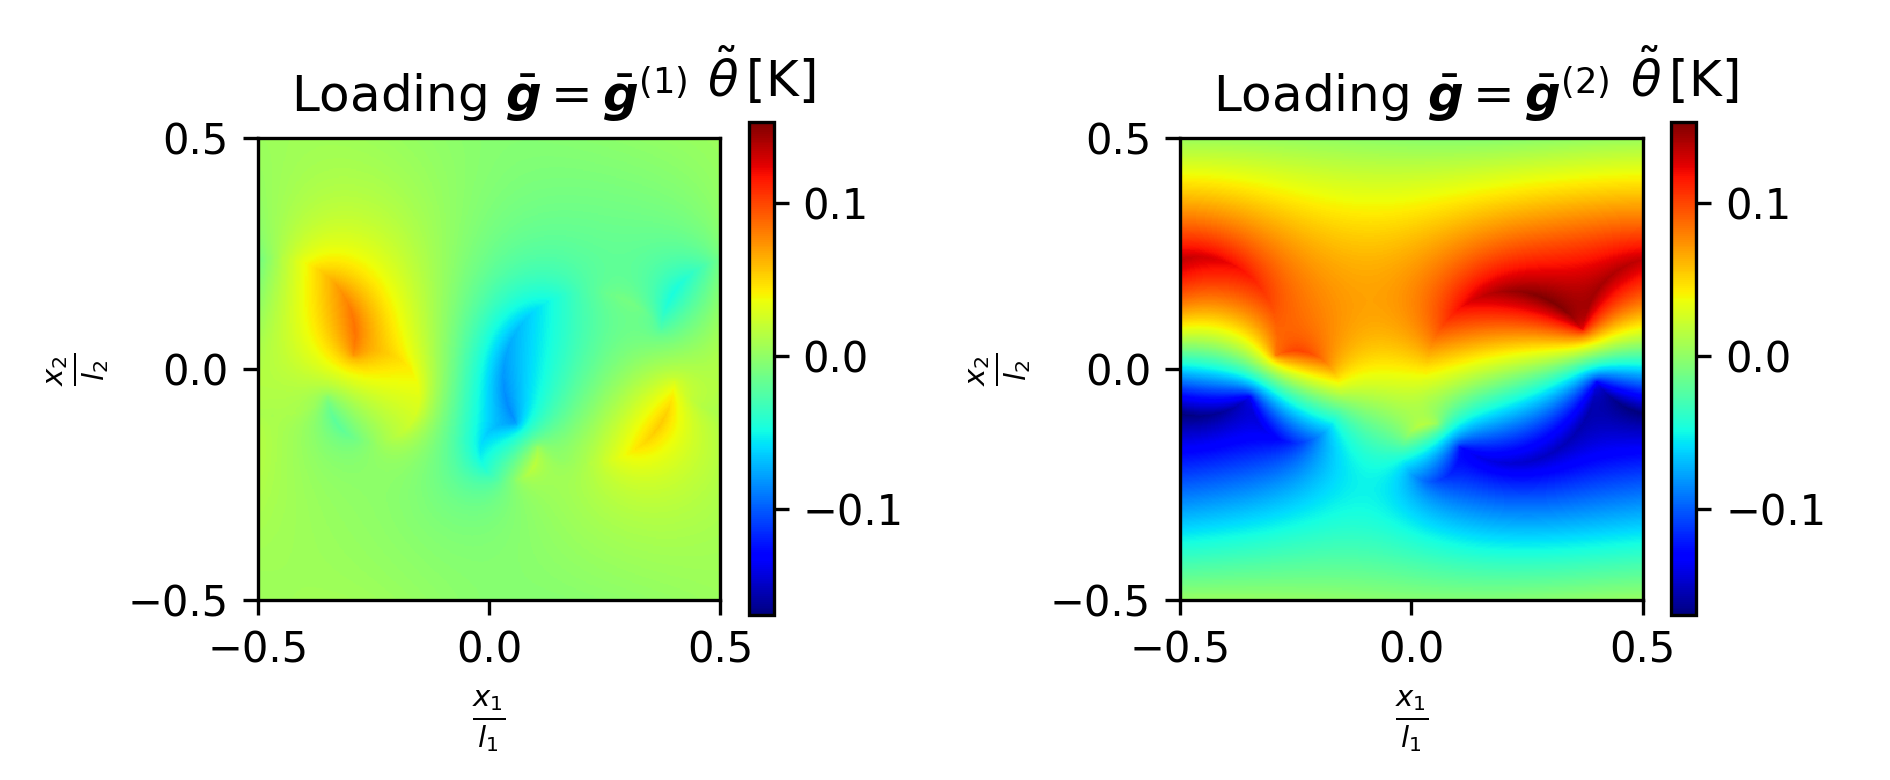

In [14]:
fig, ax = plt.subplots(1, 2, figsize=[6.3, 2.6], dpi=300)
plot_channel(temp[0,0], temp[0,1], channel=0, ax=ax, cmap="jet", plot_error=False, cbar_label=r"$\tilde{\theta} \,\mathrm{[K]}$")

for load_i, load_name in enumerate(loading_names):
    ax[load_i].set_title(rf"Loading {load_name}")
for ax_handle in ax.ravel():
    ax_handle.axis('on')
    ax_handle.set_xlim(-0.5, 0.5)
    ax_handle.set_ylim(-0.5, 0.5)
    ax_handle.set_xticks([-0.5, 0.0, 0.5])
    ax_handle.set_yticks([-0.5, 0.0, 0.5])
    ax_handle.set_xlabel(r"$\frac{x_1}{l_1}$")
    ax_handle.set_ylabel(r"$\frac{x_2}{l_2}$")
plt.tight_layout()
plt.show()

### Plot heat flux fields:

The following plot shows the components $q_1(\boldsymbol{x})$ and $q_2(\boldsymbol{x})$ of the heat flux vector-field $\boldsymbol{q}(\boldsymbol{x})$ for both load cases $\overline{\boldsymbol{g}} \in \left\{ \overline{\boldsymbol{g}}^{(1)}, \overline{\boldsymbol{g}}^{(2)} \right\}$.

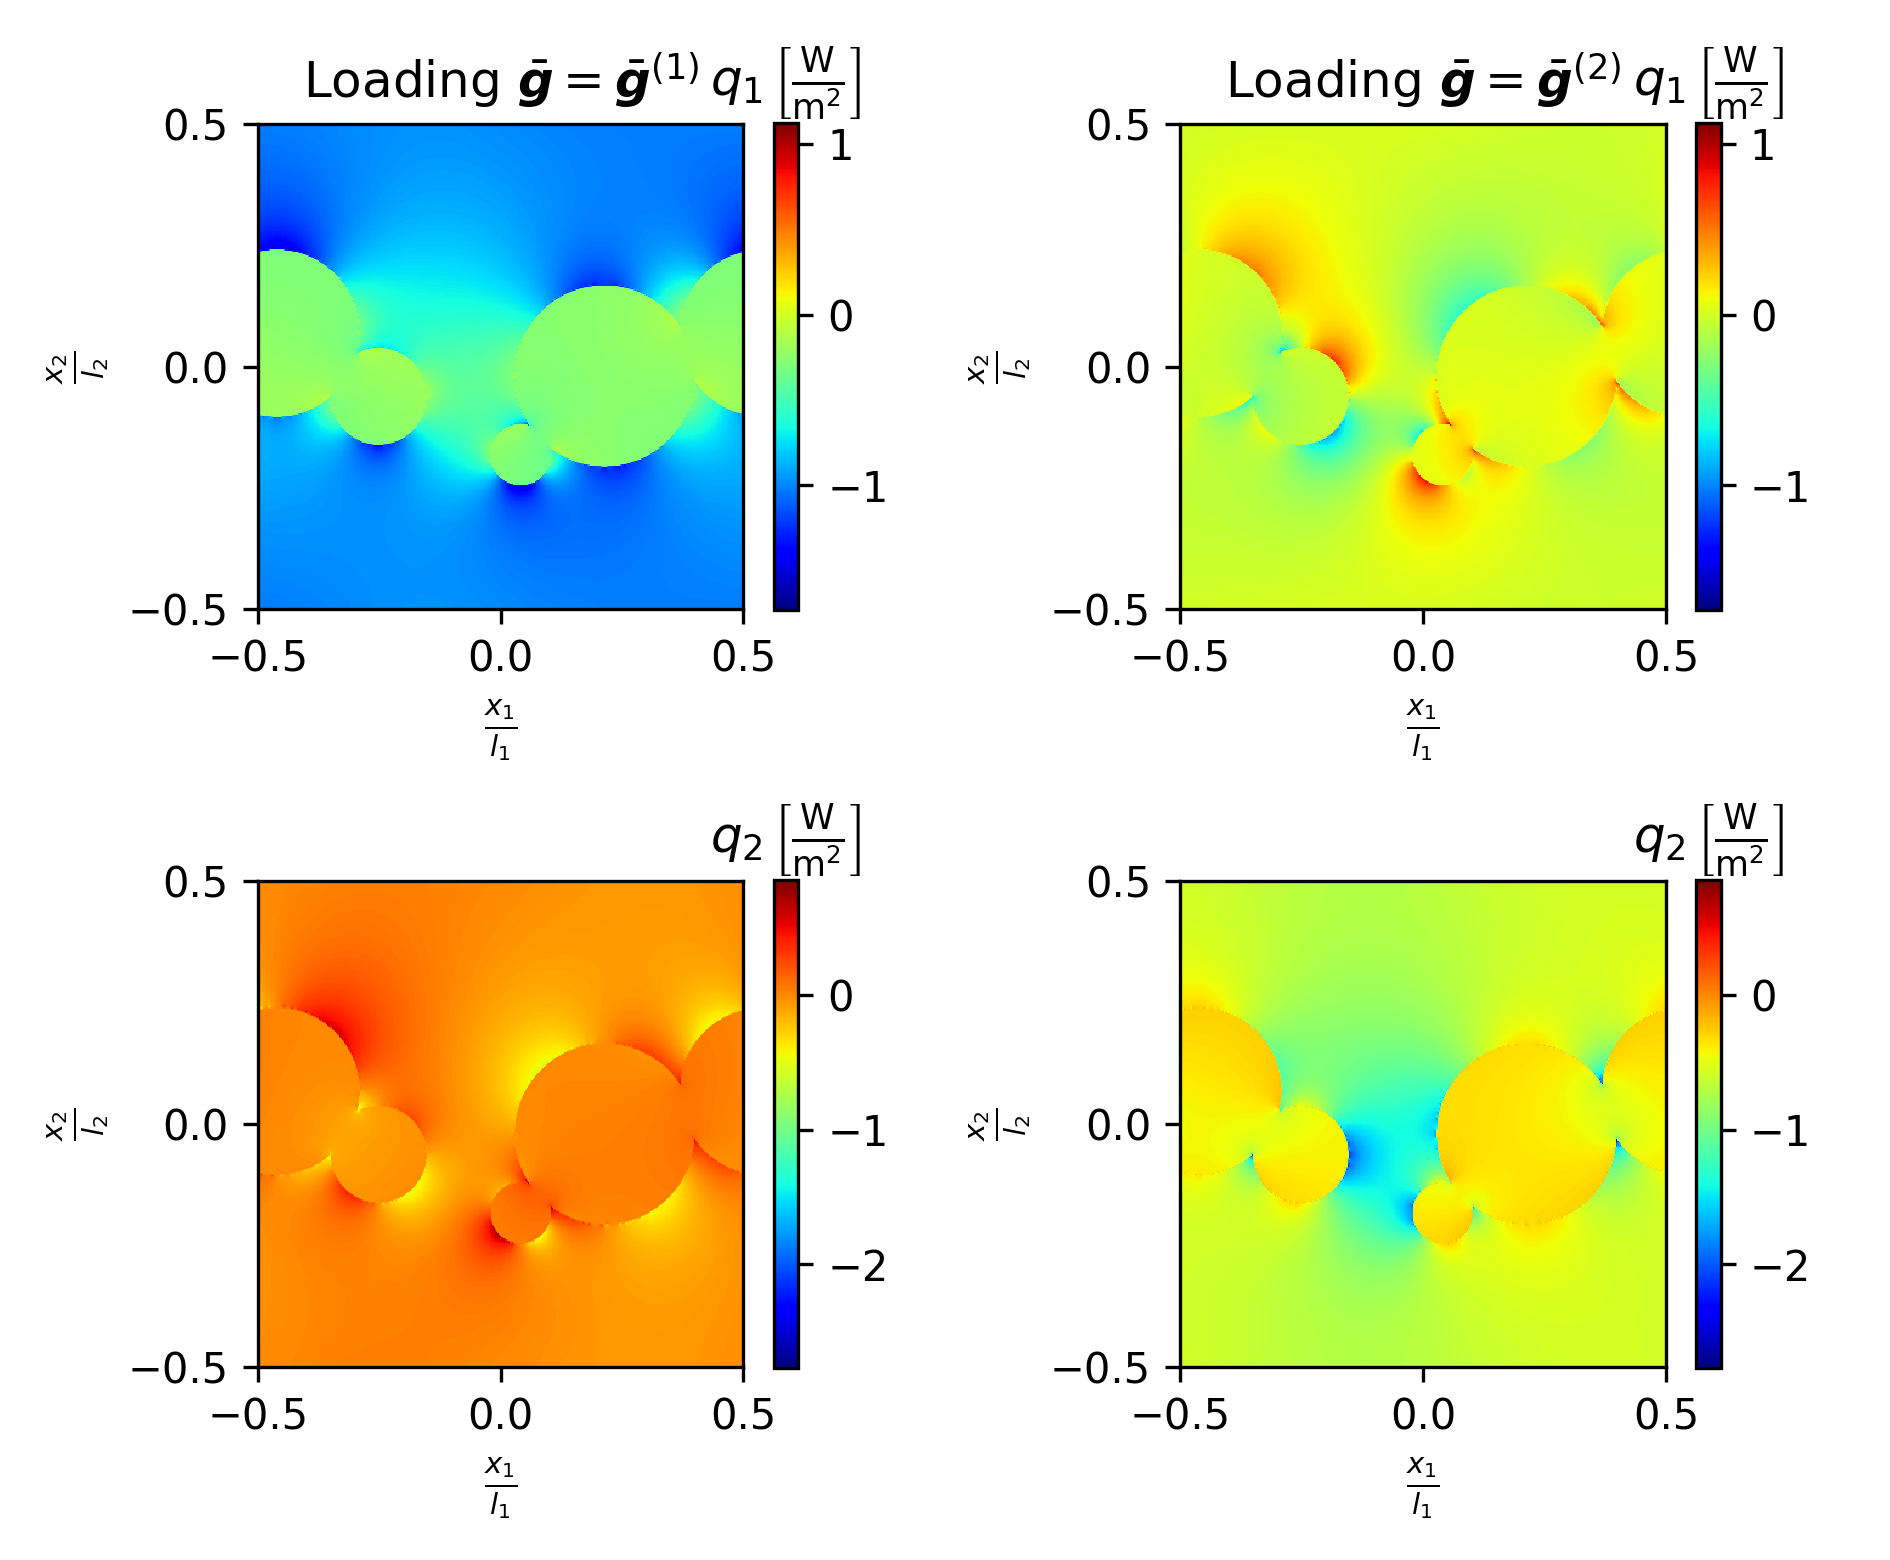

In [15]:
fig, ax = plt.subplots(2, 2, figsize=[6.3, 5.2], dpi=300)
plot_channel(flux[0,0], flux[0,1], channel=0, ax=ax[0], cmap="jet", plot_error=False, cbar_label=r"$q_1 \,\mathrm{\left[ \frac{W}{m^2} \right]}$", centered=False)
plot_channel(flux[0,0], flux[0,1], channel=1, ax=ax[1], cmap="jet", plot_error=False, cbar_label=r"$q_2 \,\mathrm{\left[ \frac{W}{m^2} \right]}$", centered=False)

for load_i, load_name in enumerate(loading_names):
    ax[0, load_i].set_title(rf"Loading {load_name}")
for ax_handle in ax.ravel():
    ax_handle.axis('on')
    ax_handle.set_xlim(-0.5, 0.5)
    ax_handle.set_ylim(-0.5, 0.5)
    ax_handle.set_xticks([-0.5, 0.0, 0.5])
    ax_handle.set_yticks([-0.5, 0.0, 0.5])
    ax_handle.set_xlabel(r"$\frac{x_1}{l_1}$")
    ax_handle.set_ylabel(r"$\frac{x_2}{l_2}$")
plt.tight_layout()
plt.show()

### Homogenized response

$$ \bar{\boldsymbol{q}} = - \bar{\boldsymbol{\kappa}} \bar{\boldsymbol{g}} $$

In [16]:
kappa_bar = -homogenize(flux).squeeze()
print('Homogenized kappa:', kappa_bar, sep='\n')
print('eig(kappa): ', torch.linalg.eigvals(kappa_bar).real)

Homogenized kappa:
tensor([[0.7589, 0.0104],
        [0.0104, 0.6345]], dtype=torch.float64)
eig(kappa):  tensor([0.7598, 0.6337], dtype=torch.float64)


### Voigt-Reuss bounds

Simple theoretical upper and lower bounds for the eigenvalues of the effective heat conductivity tensor $\bar{\boldsymbol{\kappa}}$ are available through the Voigt-Reuss bounds $\kappa_\mathrm{ub}$ and $\kappa_\mathrm{lb}$, which depend only on the volume fractions ($f_0$, $f_1$) and the material parameters ($\kappa_0$, $\kappa_1$). They are defined as
\begin{equation}
	\kappa_\mathrm{reuss} = \left( f_0 \kappa_0^{-1} + f_1 \kappa_1^{-1} \right)^{-1}
	\leq \mathrm{eig}\left( \bar{\boldsymbol{\kappa}} \right) \leq
	f_0 \kappa_0 + f_1 \kappa_1 = \kappa_\mathrm{voigt} \,.
\end{equation}

In [17]:
vol_frac = homogenize(image)
reuss = 1. / (vol_frac / params[1] + (1. - vol_frac) / params[0])
voigt = vol_frac * params[1] + (1. - vol_frac) * params[0]
print(f"reuss = {reuss.item():.4f} <= eig(kappa) <= {voigt.item():.4f} = voigt")

reuss = 0.5105 <= eig(kappa) <= 0.8082 = voigt


### Interactive widget for the thermal homogenization problem

This interactive widget allows the user to play around with different paramaters of the homogenization problem and solve it in real-time to observe their implications.
In the background, a high-fidelity simulation using the FEM on a 400x400 grid (given directly by the microstructure) is carried out on the GPU using our *FANS-CG* solver [3,4] that features a special FFT-based preconditioner tailored to this problem.
At the moment, the bottleneck of the interactive widget is not the simulation itself (about 5-10ms on a state-of-the-art GPU) but rather the visualization using matplotlib (>200ms).
With GPU-accelerated rendering via e.g. OpenCV, this could be improved greatly.

The homogenization problem is solved for two orthogonal load cases (load case 1 with $\bar{\boldsymbol{g}}=\bar{\boldsymbol{g}}^{(1)}$ and load case 2 with $\bar{\boldsymbol{g}}=\bar{\boldsymbol{g}}^{(2)}$) in order to determine the homogenized response, i.e., the effective thermal conductivity $\bar{\boldsymbol{\kappa}} \; \mathrm{[W/m^2]}$ based on a given microstructure and given phase-wise material parameters $\kappa_0, \kappa_1 \; \mathrm{[W/m^2]}$.
For simplicity, the thermal conductivity of the matrix material $\kappa_0 = 1 \; \mathrm{[W/m^2]}$ is fixed (since this is a linear problem that can be scaled arbitrarily) and the conductivity of the inclusion phase can be varied between $0.1 \leq \kappa_1 \leq 0.9 \; \mathrm{[W/m^2]}$.
In this version of the demonstrator, the user can choose between 30000 randomly generated microstructures (Microstructure id: 0-29999) with a resolution of 400x400.
In the future, it may be interesting to provide users with the ability to draw microstructures on the fly or to upload their own images.

Besides, the temperature fluctuation fields $\tilde{\theta} \; \mathrm{[K]}$, the magnitude of the heat fluxes $||\boldsymbol{q}|| \; \mathrm{[W/m^2]}$ is shown for each load case.
Above, the effective thermal conductivity $\bar{\boldsymbol{\kappa}} \; \mathrm{[W/m^2]}$ (which is a spd second-order tensor) is visualized.
For that, its eigenvalues $\mathrm{eig}(\bar{\boldsymbol{\kappa}}) \; \mathrm{[W/m^2]}$ are plotted along the theoretical Voigt/Reuss bounds and the phase-wise material parameters $\kappa_0, \kappa_1 \; \mathrm{[W/m^2]}$.
As one can observe, the eigenvalues depend highly on the microstructure and the given material parameters. However, they are always within the Voigt/Reuss bounds.
In addition to the material parameter $\kappa_1 \; \mathrm{[W/m^2]}$ and the microstructure id, the user can define the direction of the macroscopic temperature gradients $\bar{\boldsymbol{g}} \; \mathrm{[-]}$ that are imposed as loadings via the angle $\alpha \; [°]$:
\begin{equation}
    \bar{\boldsymbol{g}}^{(1)} = \begin{bmatrix} \cos \alpha \\ -\sin \alpha \end{bmatrix} \,, \quad \bar{\boldsymbol{g}}^{(2)} = \begin{bmatrix} \sin \alpha \\ \cos \alpha \end{bmatrix}
\end{equation}
While this parameter has a great effect on the full-field solutions of the heat fluxes and temperature fluctuations, the effective thermal conductivity is independent of them as expected.

Times: preprocessing 1.4429ms, simulation 9.8395ms, postprocessing 1.0946ms, surrogate 154.8007ms, plotting 223.6085ms


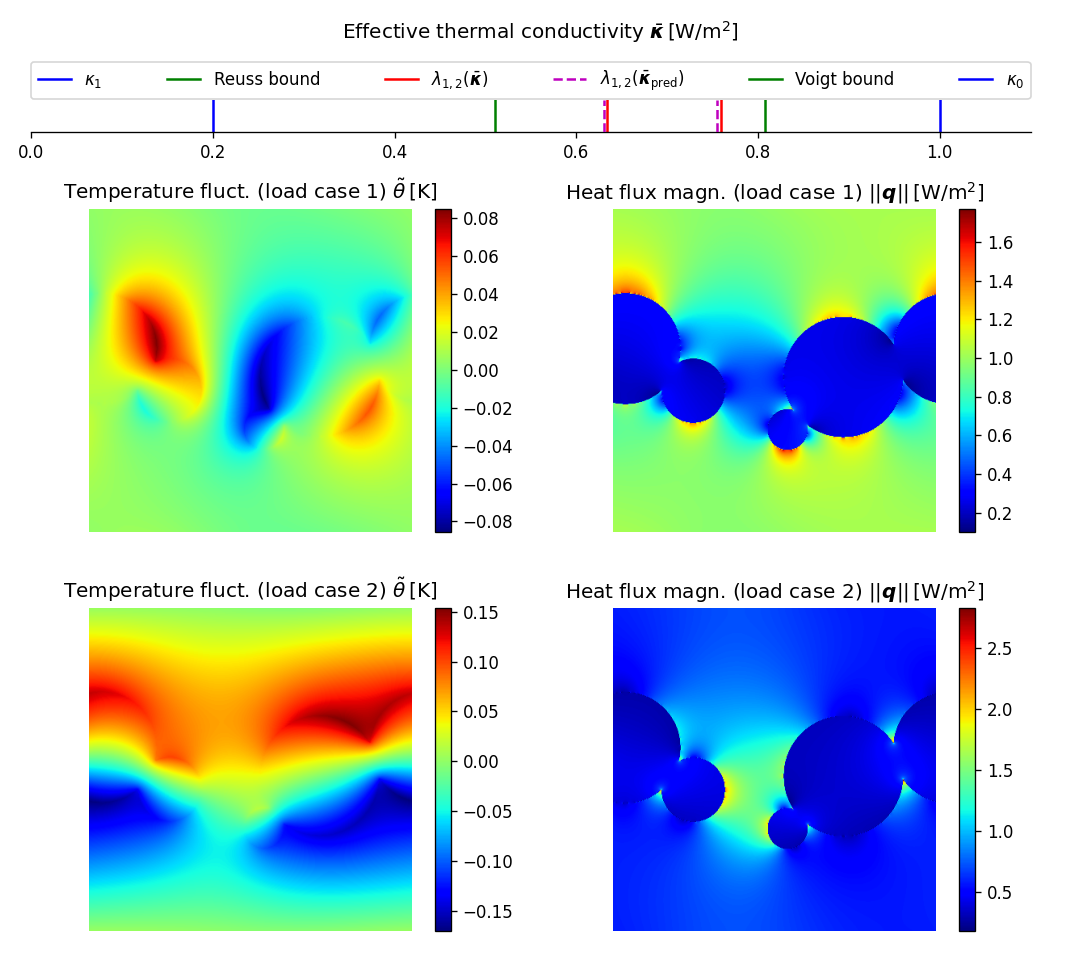

In [18]:
widget = ThermalWidget(samples=samples, model=model, surrogate=surrogate, device=device, dtype=dtype, show_colorbars=True, figsize=[9,8], dpi=120)
slider_args = {"continuous_update": False}  # for a more interactive UX this could be set to True
ms_input = ipywidgets.BoundedIntText(value=37, min=0, max=len(samples) - 1, step=1, description='Microstructure id:', disabled=False,
                                     style={'description_width': 'initial'}, layout = ipywidgets.Layout(width='200px'))
kappa1_slider = ipywidgets.FloatSlider(min=0.1, max=0.9, step=0.01, value=0.2, **slider_args, description=r"$\kappa_1 \; \mathrm{[W/m^2]}$")
alpha_slider = ipywidgets.IntSlider(min=0, max=90, step=1, value=0, **slider_args, description=r"$\alpha \; [°]$")
widget.update(ms_input.value, kappa1_slider.value, alpha_slider.value)  # dry-run
widget.update(ms_input.value, kappa1_slider.value, alpha_slider.value, print_times=True)  # benchmark
interactive_plot = ipywidgets.interactive(widget.update, ms_id=ms_input, kappa1=kappa1_slider, alpha=alpha_slider)
display(ipywidgets.HBox([ms_input, kappa1_slider, alpha_slider]))
plt.show()